# Eigenfaces and Fisherfaces - Code Supplement

In this notebook, we implement the eigenface and fisherface decomposition algorithms with the help of Python & NumPy. We train our models on the Extended Yale B dataset, then use them to classify faces from the dataset, compare their accuracy, and discuss their pros and cons.

### Importing dependencies

In [ ]:
# Core dependencies
from PIL import Image
from copy import copy
import numpy as np
import matplotlib.pyplot as plt
import os
import random

# Google Drive dependencies
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

### Downloading the dataset

Our dataset, Extended Yale B, consists of 2414 192x168 grayscale images of 39 different subjects. Its differences in variation (illumination, expressions and facial angle) make it perfect for benchmarking.

**NB:** the two cells below are designed to download the dataset via Google Drive **in Google Colab only**. On a local environment, skip these cells - instead, [download the dataset manually](https://drive.google.com/file/d/1eG_4LKguSLSuQEuDU3jMoQ1KhfRbsFD4) and extract the `CroppedYale` directory to your notebook's root folder.

In [ ]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link = 'https://drive.google.com/file/d/1eG_4LKguSLSuQEuDU3jMoQ1KhfRbsFD4'

In [ ]:
%%capture
# Download the dataset (suppressing unzip output).
downloaded = drive.CreateFile({'id':'1eG_4LKguSLSuQEuDU3jMoQ1KhfRbsFD4'}) 
downloaded.GetContentFile('CroppedYale.zip')
!rm -rf CroppedYale/
!unzip CroppedYale.zip

In [ ]:
# Inspect the dataset.
!ls
!ls CroppedYale
!ls CroppedYale/yaleB01

adc.json  CroppedYale  CroppedYale.zip	sample_data
yaleB01  yaleB06  yaleB11  yaleB17  yaleB22  yaleB27  yaleB32  yaleB37
yaleB02  yaleB07  yaleB12  yaleB18  yaleB23  yaleB28  yaleB33  yaleB38
yaleB03  yaleB08  yaleB13  yaleB19  yaleB24  yaleB29  yaleB34  yaleB39
yaleB04  yaleB09  yaleB15  yaleB20  yaleB25  yaleB30  yaleB35
yaleB05  yaleB10  yaleB16  yaleB21  yaleB26  yaleB31  yaleB36
DEADJOE			  yaleB01_P00A+020E-40.pgm  yaleB01_P00A-070E+45.pgm
WS_FTP.LOG		  yaleB01_P00A-025E+00.pgm  yaleB01_P00A+070E+45.pgm
yaleB01_P00A+000E+00.pgm  yaleB01_P00A+025E+00.pgm  yaleB01_P00A-085E-20.pgm
yaleB01_P00A+000E-20.pgm  yaleB01_P00A-035E+15.pgm  yaleB01_P00A-085E+20.pgm
yaleB01_P00A+000E+20.pgm  yaleB01_P00A+035E+15.pgm  yaleB01_P00A+085E-20.pgm
yaleB01_P00A+000E-35.pgm  yaleB01_P00A-035E-20.pgm  yaleB01_P00A+085E+20.pgm
yaleB01_P00A+000E+45.pgm  yaleB01_P00A+035E-20.pgm  yaleB01_P00A-095E+00.pgm
yaleB01_P00A+000E+90.pgm  yaleB01_P00A-035E+40.pgm  yaleB01_P00A+095E+00.pgm
yaleB01_P00A-005E-10.p

As we can see, our dataset consists of 39 folders, each containing several `pgm` images (essentially, simple uncompressed matrices of values between 0 and 255) and some extraneous metadata. We now process this dataset and convert it into a single matrix, flattening images from 192 x 168 matrices to (192 x 168) x 1 vectors in the process - this process is the **first step** of eigenface decomposition.

We also create a list of true labels corresponding to each image, which we will use later on in image classification.

In [ ]:
images, labels = [], []
print('Processing dataset...')
for dirname, dirnames, filenames in os.walk('CroppedYale'):
    for subdirname in dirnames:
        subject_path = os.path.join(dirname, subdirname)
        for filename in os.listdir(subject_path):
            if filename[-4:] == ".pgm" and "Ambient" not in filename:
                im = Image.open(os.path.join(subject_path, filename))           # open the image file
                im = im.convert("L")                                            # images are single-channel (grayscale)
                images.append(np.asarray(im, dtype=np.uint8).flatten()     )    # add image to the images array while flattening it to a 1D array
                labels.append(filename[0:7])                                    # add label (first 7 chars of filename) to labels array
images = np.array(images)
print('...done - got %d x %d matrix' % (images.shape[0], images.shape[1]))

Processing dataset...
...done - got 2414 x 32256 matrix


We now plot 10 random images from the dataset, and save their indices for later.

In [ ]:
np.random.seed(111)                                                             # fixed seed for reproducibility
random_count = 10
random_indices = np.random.choice(images.shape[0], random_count, replace=False)

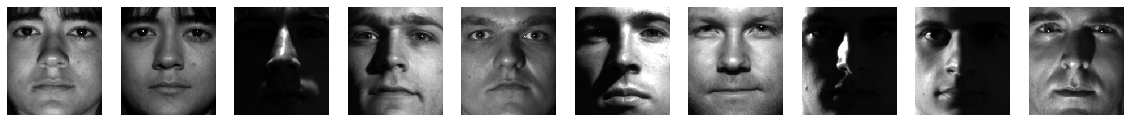

In [ ]:
plt.rcParams['figure.figsize'] = (20.0, 16.0)
for i, img in enumerate(images[random_indices]):
  plt.subplot(1, random_count, i + 1)
  plt.imshow(img.reshape(192, 168), plt.get_cmap('gray'));
  plt.axis('off')
plt.show()

### Computing eigenfaces

The **second step** of eigenface decomposition is calculating the average face, and subtracting it from all other images in the dataset. We do just that, saving the matrix of mean-subtracted images into a new variable and visualizing the dataset's "mean face".

In [ ]:
mean_image = images.mean(axis = 0)
mean_subtracted_images = images - mean_image

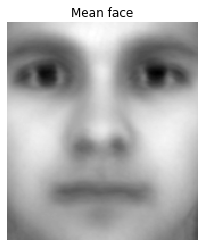

In [ ]:
plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.imshow(mean_image.reshape(192, 168), plt.get_cmap('gray'));
plt.axis('off')
plt.title('Mean face')
plt.show()

The **third** and **fourth steps** are to calculate the eigenvalues and eigenvectors of the covariance matrix $C = A A^\top$, where $A$ is the matrix of mean-subtracted faces. However, since computing a 32256 x 32256 matrix is computationally infeasible, we instead calculate the eigenvalues and eigenvectors of the much smaller matrix $A^\top A$. Its eigenvalues are identical to the eigenvalues of $C$, whereas the eigenvectors of $C$ can be obtained after left-multiplying the eigenvalues of $A^\top A$ by $C$.

**NB:** For performance reasons, we only calculate the first 200 eigenfaces.

In [ ]:
print('Computing eigenvalues and eigenvectors... (may take 30-60 seconds)')
eigenvals, eigenvecs = np.linalg.eig(mean_subtracted_images @ mean_subtracted_images.T)

print('Computing 200 eigenfaces... (may take 5-10 minutes!)')
eigenfaces = mean_subtracted_images.T @ eigenvecs[:,:200]

Computing eigenvalues and eigenvectors... (may take 30-60 seconds)
Computing 200 eigenfaces... (may take 5-10 minutes!)


We must also normalize the vector of eigenfaces so that they may be used to decompose and recreate images later on.

In [ ]:
normalized_eigenfaces = eigenfaces.T / np.linalg.norm(eigenfaces.T, axis=-1)[:, np.newaxis]

### Visualizing eigenfaces

We now visualize the first thirty eigenfaces (they are automatically sorted by their corresponding eigenvalues).

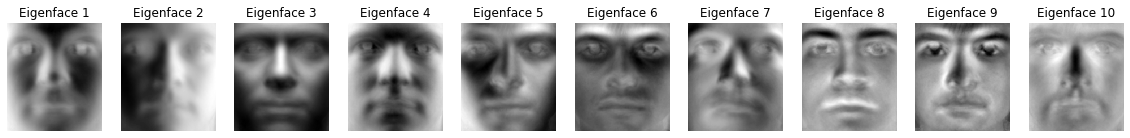

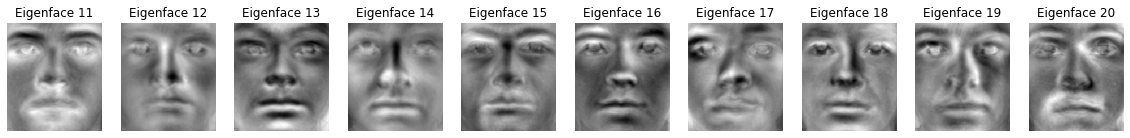

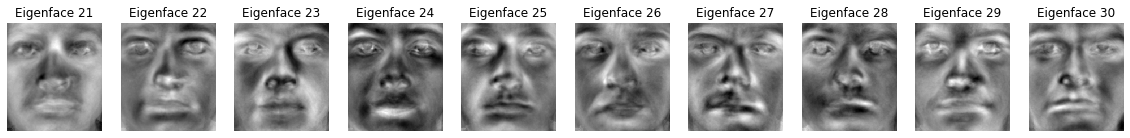

In [ ]:
plt.rcParams['figure.figsize'] = (20.0, 16.0)

def show_faces(n, offset = 0):
  for i, img in enumerate(normalized_eigenfaces[offset:offset+n]):
    plt.subplot(1, n, i + 1)
    plt.imshow(img.reshape(192, 168), plt.get_cmap('gray'));
    plt.title('Eigenface %d' % (i + 1 + offset))
    plt.axis('off')
  plt.show()

show_faces(10)
show_faces(10, 10)
show_faces(10, 20)

Eigenfaces are particularly sensitive to illumination, and we can see that the first six of them appear to encode information about an image's dark spots. Some of them appear to represent distinctive facial features: thick brows for #8, a darker nose for #10 and so forth. Later eigenfaces are, however, far more difficult to interpret.

We now take five faces from the list we've originally visualized, convert them from a matrix to a vector of eigenface weights and back again. How much eigenfaces do we need to use to reliably reconstruct an image?

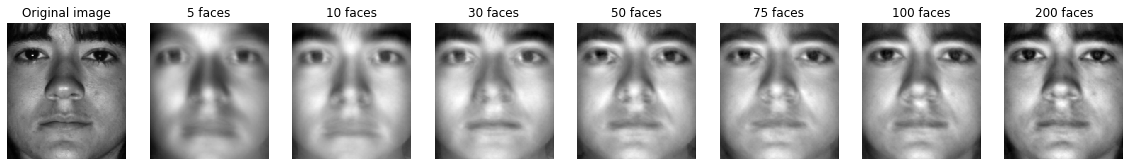

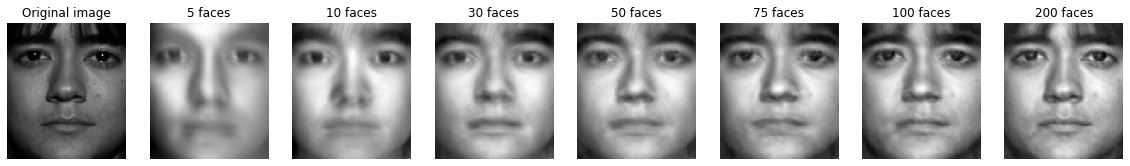

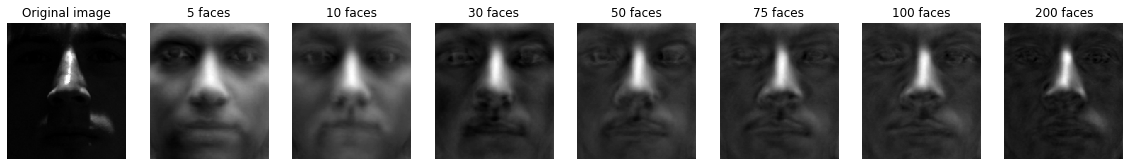

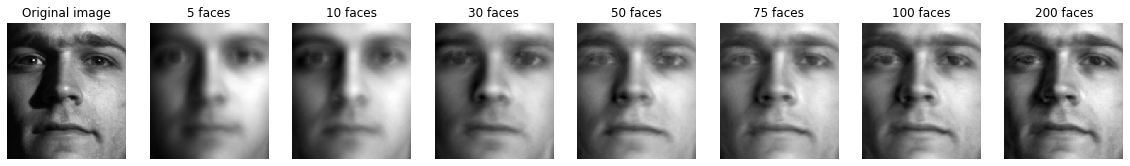

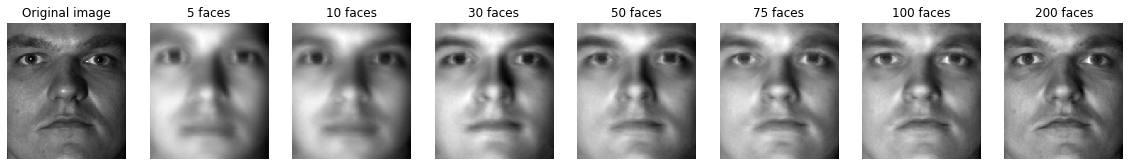

In [ ]:
plt.rcParams['figure.figsize'] = (20.0, 16.0)
face_counts = [None, 5, 10, 30, 50, 75, 100, 200]
for img in mean_subtracted_images[random_indices][0:5]:                         # take the first five faces 
  for i, n_vectors in enumerate(face_counts):
    recon = copy(img)                                                           # shallow-copy the image so it doesn't get overwritten!
    if n_vectors is not None:
      decon = img @ normalized_eigenfaces[:n_vectors].T                         # convert the face matrix to a weight vector
      recon = decon @ normalized_eigenfaces[:n_vectors]                         # convert the weight vector to a face matrix
    recon = recon + mean_image                                                  # so far, we've been working with mean-subtracted faces; add the mean back to the image
    plt.subplot(1, len(face_counts), i + 1)
    plt.imshow(recon.reshape(192, 168), plt.get_cmap('gray'));
    if n_vectors is None:
      plt.title('Original image')
    elif n_vectors == 1:
      plt.title('1 face')
    else:
      plt.title('%d faces' % n_vectors)
    plt.axis('off')
  plt.show()

As we can see, the face's illumination is reliably reproduced by as few as five eigenfaces. By 30-50 eigenfaces, the reconstructed face start resembling the original subject, and subtler features such as wrinkles or pimples start becoming distinct at 100-200 faces. If we were to use all 2414 eigenfaces, the image would be reconstructed back to its original form.

### Evaluating eigenfaces

One way to evaluate the number of eigenfaces needed to represent an image is by computing explained variance, a value that quantifies how much of the variance in the original image is captured by the chosen principal components.

In [ ]:
variance = {}
total = np.sum(eigenvals)
for i in range(0, 80):
  variance[i + 1] = 100 * np.sum(eigenvals[0:i]) / total

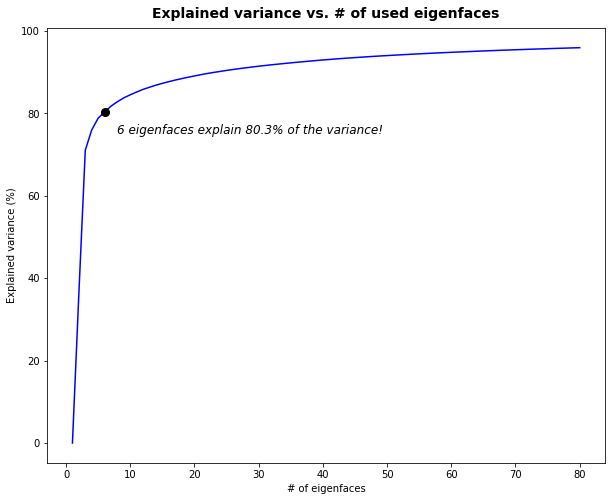

In [ ]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('Explained variance vs. # of used eigenfaces', fontweight = "bold", fontsize=14, pad=10)
ax.set_xlabel('# of eigenfaces')
ax.set_ylabel('Explained variance (%)')
ax.text(8, 75, '%d eigenfaces explain %.1f%% of the variance!' % (list(variance.keys())[5], list(variance.values())[5]), fontsize=12, style="italic")
ax.plot(*zip(*variance.items()), 'b-')
ax.plot(list(variance.keys())[5], list(variance.values())[5], marker='o', markersize=8, color="black")
plt.show()

### Image classification with eigenfaces

Once eigenfaces for a dataset are computed, a new image introduced to it can be classified as follows:
- Normalize the face (by subtracting the mean);
- Find the weights of the face;
- Calculate the distances between the weights of all faces in the dataset and the weight of the new face;
- Classify it as the class of its closest neighbor.

We now to classify 5 faces randomly chosen from the dataset against the dataset with those faces excluded, and visualize their classification.

In [ ]:
faces = normalized_eigenfaces.T
all_weights = mean_subtracted_images @ faces
min_indices = {}
for i, img in enumerate(mean_subtracted_images[random_indices][0:5]):           # 1. take 5 faces (already normalized)
  weights = img @ faces                                                         # 2. find their weights
  distances = np.linalg.norm(all_weights - weights, axis = 1)                   # 3. calculate the distances to all other faces
  distances[random_indices[i]] = np.inf                                         # (a face cannot be its own closest neighbor)
  min_indices[random_indices[i]] = np.argmin(distances)                         # 4. store its closest neighbor

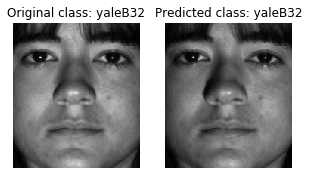

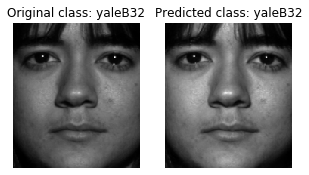

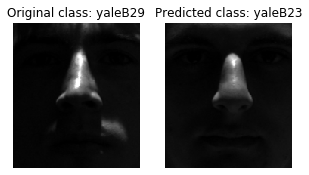

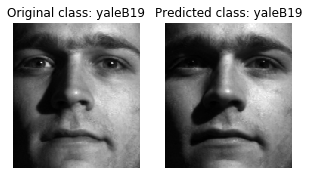

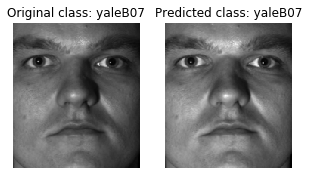

In [ ]:
plt.rcParams['figure.figsize'] = (5.0, 4.0)
for k, v in min_indices.items():
  plt.subplot(1, 2, 1)
  
  plt.imshow(images[k].reshape(192, 168), plt.get_cmap('gray'));
  plt.title('Original class: %s' % labels[k])
  plt.axis('off')

  plt.subplot(1, 2, 2)
  plt.imshow(images[v].reshape(192, 168), plt.get_cmap('gray'));
  plt.title('Predicted class: %s' % labels[v])
  plt.axis('off')

  plt.show()

We can see that all the faces have been correctly predicted, except for a particularly dark image - the reliance on illumination as a feature is a known issue of the eigenface method. We now run more comprehensive leave-one-out cross-validation on the entire dataset with varying numbers of chosen eigenfaces, and plot the results.

In [ ]:
def compute_accuracy(drop=0):
  accuracy = {}
  total = mean_subtracted_images.shape[0]
  print('Computing accuracy, dropping %d first faces (may take 3-5 minutes!)' % drop)
  for n_vectors in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]:
    faces = normalized_eigenfaces[drop:n_vectors].T                                   # take a subset of eigenfaces
    all_weights = mean_subtracted_images @ faces                                  # find all weights
    accurate = 0                                                                  # store # of accurately labeled faces
    for i, img in enumerate(mean_subtracted_images):                              # 1. iterate through all faces
      weights = img @ faces                                                       # 2. find the weight of an individual face
      distances = np.linalg.norm(all_weights - weights, axis = 1)                 # 3. calculate the distances to all other faces
      distances[i] = np.inf                                                       # (a face cannot be its closest neighbor)
      min_index = np.argmin(distances)                                            # 4. store its closest neighbors
      if labels[i] == labels[min_index]:                                          # if the label of a face is the same as its closest neighbor...
        accurate += 1                                                             # ...increment the # of accurately classified faces
    accuracy[n_vectors] = 100 * accurate / total                                  # store the accuracy for this number of eigenfaces
  return accuracy
accuracy = compute_accuracy()

Computing accuracy, dropping 0 first faces (may take 3-5 minutes!)


One method of coping with illunination distraction is to discard the first three eigenfaces from the dataset, with the assumption that they encode information about illumination only. We now try this method in action.

In [ ]:
drop_3_accuracy = compute_accuracy(3)
drop_6_accuracy = compute_accuracy(6)

Computing accuracy, dropping 3 first faces (may take 3-5 minutes!)
Computing accuracy, dropping 6 first faces (may take 3-5 minutes!)


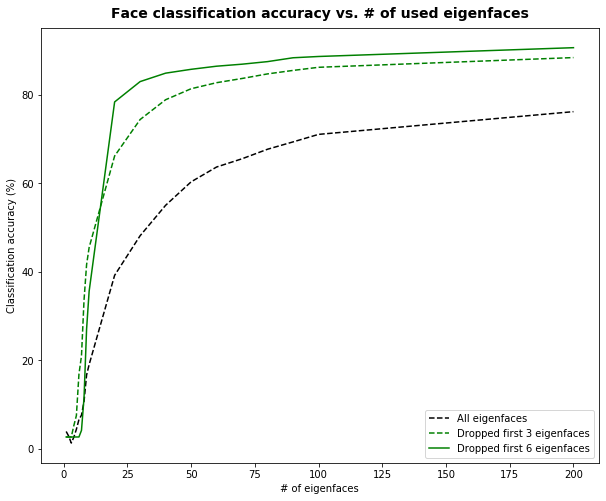

In [ ]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('Face classification accuracy vs. # of used eigenfaces', fontweight = "bold", fontsize=14, pad=10)
ax.set_xlabel('# of eigenfaces')
ax.set_ylabel('Classification accuracy (%)')
ax.plot(*zip(*accuracy.items()), 'k--', label='All eigenfaces')
ax.plot(*zip(*drop_3_accuracy.items()), 'g--', label='Dropped first 3 eigenfaces')
ax.plot(*zip(*drop_6_accuracy.items()), 'g-', label='Dropped first 6 eigenfaces')

ax.legend()
plt.show()

Indeed, dropping the first three eigenfaces appears to significantly improve performance. Larger numbers, however, lead to diminishing returns - and increasing this even further is likely to decrease accuracy, as useful variance is left out from the eigenvectors.

### Computing fisherfaces

We will now move on to computing fisherfaces, starting by calculating the mean image for each class (purely for visualization purposes).

In [ ]:
uniqueLabels = np.unique(labels)                                                # Unique dataset labels
labels = np.array(labels)
class_mean_images = []
for i, label in enumerate(uniqueLabels):
    indices = np.flatnonzero(labels == label)                                   # Group indices by unique label
    class_images = images[indices, :]                                           # Group matrices by label
    class_mean_image = class_images.mean(axis=0)                                # Calculate the mean image for this class and add it to the dictionary
    class_mean_images.append(class_mean_image)
class_mean_images = np.array(class_mean_images)

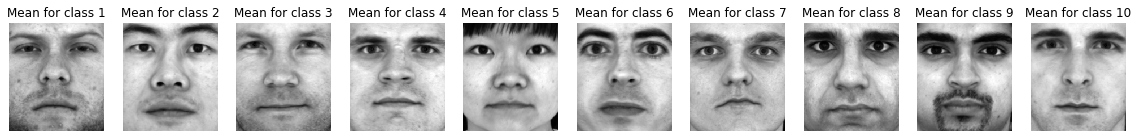

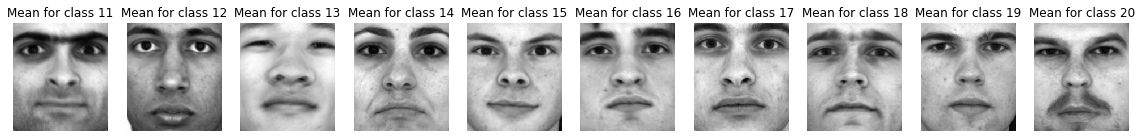

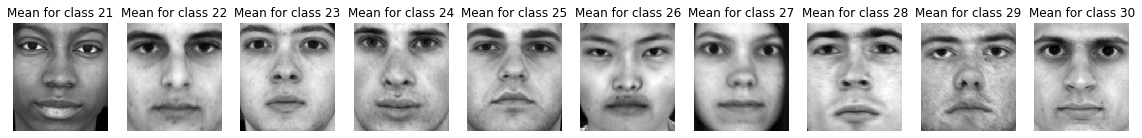

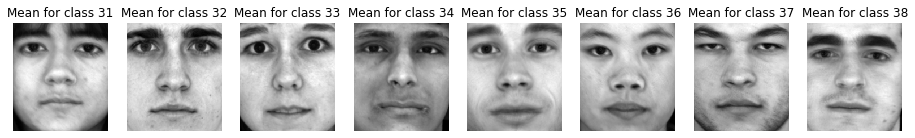

In [ ]:
plt.rcParams['figure.figsize'] = (20.0, 16.0)

def show_class_mean_images(n, offset = 0):
  for i, img in enumerate(class_mean_images[offset:offset+n]):
    plt.subplot(1, n, i + 1)
    plt.imshow(img.reshape(192, 168), plt.get_cmap('gray'));
    plt.title('Mean for class %d' % (i + 1 + offset))
    plt.axis('off')
  plt.show()

show_class_mean_images(10)
show_class_mean_images(10, 10)
show_class_mean_images(10, 20)
show_class_mean_images(10, 30)

We can see that the mean faces are reasonable approximations of each subject face, and that they have a similar level of illumination - which is important for preventing extraneous variance. We now go through the steps of the fisherface algorithm itself, reusing the normalized eigenface vector from earlier.

In [ ]:
projected_data = np.dot(mean_subtracted_images, normalized_eigenfaces.T)
size = projected_data.shape[1]                
Sw_class_scatter_matrix = np.zeros((size, size), dtype = float)                 # stub out the within-class scatter matrix
Sb_class_scatter_matrix = np.zeros((size, size), dtype = float)                 # stub out the between-class scatter matrix
mean_proj_matrix = projected_data.mean(axis=0) 
for label in uniqueLabels:
  class_samples = projected_data[np.where(labels==label)[0],:]
  mean_class = class_samples.mean(axis=0)
  # add the current class deviation to the within-class scatter matrix...
  Sw_class_scatter_matrix = Sw_class_scatter_matrix + np.dot((class_samples - mean_class).transpose(), (class_samples - mean_class))
  # ...and between-class scatter matrix
  Sb_class_scatter_matrix = Sb_class_scatter_matrix + projected_data.shape[0] * np.dot((mean_class - mean_proj_matrix).transpose() , (mean_class - mean_proj_matrix))

In [ ]:
eigenvalues_lda, eigenvectors_lda = np.linalg.eig(np.linalg.inv(Sw_class_scatter_matrix)* Sb_class_scatter_matrix) # get the LDA eigenvalues and eigenvectors
indexes = np.argsort(-eigenvalues_lda.real)
eigenvalues_lda=eigenvalues_lda[indexes] 
eigenvectors_lda = eigenvectors_lda[:, indexes ]
components_number = len(uniqueLabels)-1                                         # get the first C - 1 eigenvectors
eigenvalues_lda_subtr = np.array(eigenvalues_lda[0:components_number].real, dtype = np.float32 , copy = True )
eigenvectors_lda_subtr = np.array(eigenvectors_lda[0: ,0:components_number].real, dtype = np.float32 , copy = True )
fisherfaces = np.dot(normalized_eigenfaces.T, eigenvectors_lda_subtr)           # compute the final fisherface matrix

Afterwards, we visualize the fisherfaces for each individual class - note the similarities to the class mean images.

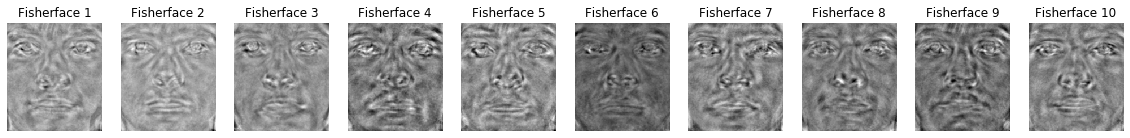

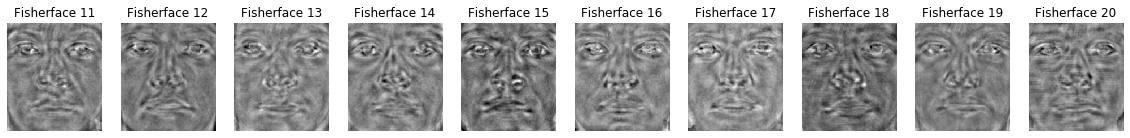

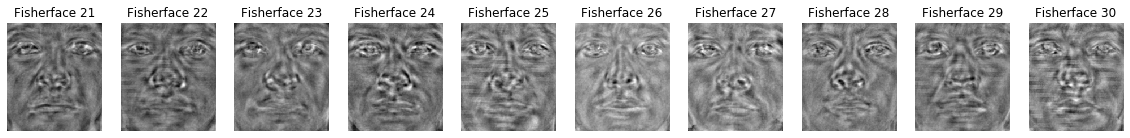

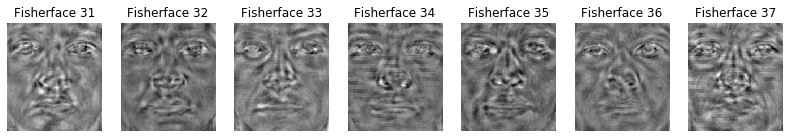

In [ ]:
plt.rcParams['figure.figsize'] = (20.0, 16.0)

def show_fisherfaces(n, offset = 0):
  for i, img in enumerate(fisherfaces.T[offset:offset+n]):
    plt.subplot(1, n, i + 1)
    plt.imshow(img.reshape(192, 168), plt.get_cmap('gray'));
    plt.title('Fisherface %d' % (i + 1 + offset))
    plt.axis('off')
  plt.show()

show_fisherfaces(10)
show_fisherfaces(10, 10)
show_fisherfaces(10, 20)
show_fisherfaces(10, 30)

Finally, we run leave-one-out cross-validation with the fisherface algorithm, and then compare it to eigenface accuracies. 

In [ ]:
def fisherface_accuracy():
    accuracy = {}
    total = mean_subtracted_images.shape[0]
    print('Computing fisherface accuracy (may take 3-5 minutes!)')
    for n_vectors in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]:
        faces = fisherfaces.T[:n_vectors]                                       # take a subset of fisherfaces
        all_weights = mean_subtracted_images @ faces.T                          # find all weights
        accurate = 0                                                            # store # of accurately labeled faces
        for i, img in enumerate(mean_subtracted_images):                        # 1. iterate through all faces
            weights = img @ faces.T                                             # 2. find the weight of an individual face
            distances = np.linalg.norm(all_weights - weights, axis = 1)         # 3. calculate the distances to all other faces
            distances[i] = np.inf                                               # (a face cannot be its closest neighbor)
            min_index = np.argmin(distances)                                    # 4. store its closest neighbors
            if labels[i] == labels[min_index]:                                  # if the label of a face is the same as its closest neighbor...
                accurate += 1                                                   # ...increment the # of accurately classified faces
        accuracy[n_vectors] = 100 * accurate / total                            # store the accuracy for this number of fisherfaces
    return accuracy
fisherface_accuracy = fisherface_accuracy()

Computing fisherface accuracy (may take 3-5 minutes!)


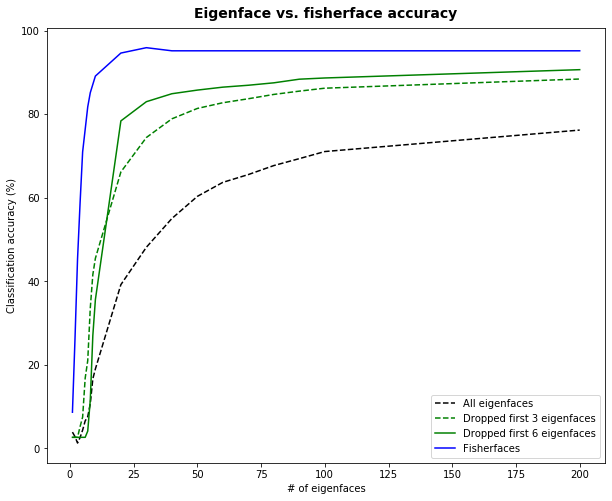

In [ ]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('Eigenface vs. fisherface accuracy', fontweight = "bold", fontsize=14, pad=10)
ax.set_xlabel('# of eigenfaces')
ax.set_ylabel('Classification accuracy (%)')
ax.plot(*zip(*accuracy.items()), 'k--', label='All eigenfaces')
ax.plot(*zip(*drop_3_accuracy.items()), 'g--', label='Dropped first 3 eigenfaces')
ax.plot(*zip(*drop_6_accuracy.items()), 'g-', label='Dropped first 6 eigenfaces')
ax.plot(*zip(*fisherface_accuracy.items()), 'b-', label='Fisherfaces')

ax.legend()
plt.show()

Quickly approaching its best accuracy of 95.15%, the fisherface method is far more accurate than even the modified eigenface classifier.